# Wind Analysis Of Northern Yucatan Coast for Kiteboarding

## Table of Contents

1. one
  1. two
  1. three
2. four
  2. five


## Introduction

### Motivation

Back in 2017 I had the curiosity of knowing how good the wind was for a kiteboarding spot close to my hometown in order to find the best time to go there that maximizes the number of kiting days. Local riders said it was always good but was that true?

This work started originally as an R school project. This notebook is the same project ported to spark adding more years of analysis. The pipeline of the project goes like this:

$$Load\ Sensor\ Data \rightarrow Basic\ Cleanup \rightarrow Interpolation\ to\ Equally\ Spaced \rightarrow Removal\ of\ Night\ Time\ Readings \rightarrow Analysis\ and\ Plots$$

Two things that originally looked challenging were the creation of an equally spaced time series with  interpolation and the measurements of time ranges that were done in the original project.

### Dependencies

#### Libraries

This is the list of libraries needed.

In [1]:
%matplotlib inline
# Dataframe:
import pandas as pd
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from pyspark.sql.dataframe import DataFrame

# Daylight UDF:
import astral
from datetime import datetime
from pyspark.sql.types import TimestampType

# Plot related
import matplotlib.pyplot as plt
import calendar
import calmap

# Math
import math
import numpy as np

# Access of env vars
import os

#### Requirements

Spark version 2.4.0 or above is required since it uses sequence and PIVOT in SQL.

In [2]:
from distutils.version import StrictVersion
assert StrictVersion(spark.version) >= StrictVersion('2.4.0'), "Notebook requires spark 2.4.0 or above"

#### Constants

In [3]:
FIVE_MINUTES_IN_SECS = (5*60) # Seconds
TWO_HOURS_IN_5MINS = (2*60)//5 #how many 5 min periods in 2 hours
MIN_SAMPLE_COUNT = 100
DATABRICKS_ENV = 'DATABRICKS_RUNTIME_VERSION' in os.environ.keys()

#### Transform

This is a nice trick to provide functionality similar to scala transform.

Source : https://medium.com/@mrpowers/chaining-custom-pyspark-transformations-4f38a8c7ae55

In [4]:
def transform(self, f):
    return f(self)

DataFrame.transform = transform

## The Data

### Weather Station

The weather station (PWS) used for this analysis is CINVESTAV Telchac located in the Northern Yucantan coast. Coordinates of the station are latitude 21.341108 and longitude -89.305756. This is a single PWS project so spark will be configured in the timeszone of the project and there will be a location object for the PWS.

In [5]:
pwsID = 'IYUCATNT2'
pwsTz = 'America/Merida'
sensorLoc = astral.Location(("Telchac", "Mexico", 21.341108, -89.305756, pwsTz, 0))
spark.conf.set("spark.sql.session.timeZone", pwsTz)

### Data Source

The information was gathered from Weather Underground web site that provides a free API to gather the information of a particular day. The weather station ID for this location is IYUCATNT2. The response comes almost in a CSV format except for the insertion of "br" html tags.

For instance the following URL will provide the data for January 1st, 2016:

https://www.wunderground.com/weatherstation/WXDailyHistory.asp?ID=IYUCATNT2&month=1&day=1&year=2016&format=1

A crawler script (with some wait between request) was created to dump the sensor information and do the simple task of converting it to a CSV (removing the inserted tags). The data is organized in subdirectories for the station ID, year and month for easy management.

In [6]:
# Databricks location or local:
fileStorePath = "/FileStore/tables/test1" if DATABRICKS_ENV else "./"

unformattedWindDF = spark.read \
    .format("csv") \
    .option("header","true") \
    .load("{}/dailyHistory/{}/*/*/*.csv".format(fileStorePath,pwsID))

### Dataset

The sensor has historical data only from the middle of 2008 so the range for this analysis is from 2009 to 2018.

The table that Weather Underground returns has a lot of columns that represent measurements from the PWS like pressure, temperature, dew point, etc. but for this analysis we only focused on the following:

__Time__ : This is the timestamp at which the sample is taken in the local timezone of the PWS. There is another column that has the time in UTC but not used in this analysis. This column is kept as a string for comparison.

__WindDirectionDegrees__ : This is the wind direction in degrees. The cardinal directions map as follow: North is 0, East is 90, South is 180 and West is 270. This is casted to integer.

__WindSpeedMPH__ : Wind speed measured in miles per hour (mph). There is also a gust wind speed column but not used in this analysis. This is casted to a double.

The following columns are derived from the previous:

__TS__ : Conversion of the _Time_ string to a timestamp. Casting from string to timestamp was the best method posible found to handle timestamps in the PWS timezone.

__Date__ : Extraction of the date portion of the timestamp.

__TSEpochSec__ : Number of seconds since the UNIX epoch time of the current timestamp. Obtained by casting the timestamp to a long.


In [7]:
windFormattedDF = unformattedWindDF.selectExpr(
    "Time",
    "to_timestamp(Time,'yyyy-MM-dd HH:mm:ss') as TS",
    "cast(WindDirectionDegrees as integer)",
    "cast(WindSpeedMPH as double)") \
    .withColumn("Date",col("TS").cast("date")) \
    .withColumn("TSEpochSec",col("TS").cast("long"))

windFormattedDF.printSchema()

root
 |-- Time: string (nullable = true)
 |-- TS: timestamp (nullable = true)
 |-- WindDirectionDegrees: integer (nullable = true)
 |-- WindSpeedMPH: double (nullable = true)
 |-- Date: date (nullable = true)
 |-- TSEpochSec: long (nullable = true)



## Data Cleanup

### Readings Cleanup

#### Bad Readings

It was noticed that readings where the WindSpeedMPH is 0.0 come with a very high negative WindDirectionDegrees. This could add some noise when resampling so they are converted to 0.

There are also some -999.0 values for WindSpeedMPH which seem to be the way the sensor reports some NA or lack of a good reading, they also come with a very high positive WindDirectionDegrees (more than 360). These readings are dropped.

Finally a few readings come with a very high WindDirectionDegrees. Again these are dropped.

In [8]:
windNoBadReadingsDF = windFormattedDF \
    .withColumn(
        "WindDirectionDegrees",
        when(col("WindDirectionDegrees")==-737280,0).otherwise(col("WindDirectionDegrees"))) \
    .filter(col("WindSpeedMPH")>=0.0) \
    .filter(col("WindDirectionDegrees").between(0,360))

#### Small Daily Sample Set

After getting rid of the bad readings the next step is to find the days that don’t have enough readings and then drop them. The threshold used for this notebook is 100 but it is parametrized in the constant section.

In [9]:
def enoughSamplesPerDayTrans(srcDF, minSampleCount) :
    return ( srcDF
        .groupBy("Date")
        .agg(count(lit(1)).alias("SampleCount"))
        .filter(col("SampleCount")>=lit(minSampleCount)) )
    
windDF = windNoBadReadingsDF.join(
    enoughSamplesPerDayTrans(windFormattedDF,MIN_SAMPLE_COUNT),
    ["Date"],
    "left_semi")

### Transform to Equally Spaced Observations

The minimum difference between readings of the same day is intended to be 5 minutes but there are situations when the reading for the next 5 min is not taken or the period shifts or in rare occasions is less than 5 min.

For our final analysis we would like to find periods of contiguous readings. For this it is easier if the readings are equally spaced in 5 min samples. This will be done by resampling and interpolating the unknown intermediate values from the known ones.

Spark currently doesn’t have the same support as R with regards of time series so this has to be done in different stages.

#### Combining Current and Next Reading with a Window

We need to apply a window function to get the next reading (lead) together with the current one in order to interpolate values between them. The last value of the window will have a null and will be dropped since it is not crucial for this analysis (most likely dropped later).

In [10]:
windowSpec = Window.partitionBy("Date").orderBy("TS")

windPairDF = windDF \
    .withColumn("nextWindDirectionDegrees",lead("WindDirectionDegrees").over(windowSpec)) \
    .withColumn("nextWindSpeedMPH",lead("WindSpeedMPH").over(windowSpec)) \
    .withColumn("nextTSEpochSec",lead("TSEpochSec").over(windowSpec)) \
    .dropna(subset=["nextTSEpochSec"])

#### Next Wind Direction With Shortest Angle

In case of boundary conditions between 0 and 360 degrees representing the north we will have a problem when doing interpolation. For instance interpolating values between 5 degrees and 355 degrees may take values between these two numbers which will be incorrect. To overcome this problem we have to calculate what is the shortest angle separation between those 2 readings and then calculate the new next direction based on this.

The one-liner for the shortest angle was obtained from a discussion in stack overflow:

$$( ( (\theta-\phi) \% 2\pi ) + 3\pi ) \% 2\pi ) - \pi$$

Sources:
https://stackoverflow.com/questions/2708476/rotation-interpolation/14498790#14498790 ,
https://math.stackexchange.com/questions/2144234/interpolating-between-2-angles


In [11]:
def shortestAngleExpr(fromAngle, toAngle) :
    return ( ( ( ( (toAngle-fromAngle) % lit(360) ) + lit(540) ) % lit(360) ) - lit(180) )

def shortestNextAngleExpr(fromAngle, toAngle) :
    return fromAngle + shortestAngleExpr(fromAngle, toAngle)

windPairFixDirDF = windPairDF \
    .withColumn("oldNextWindDeg",
                col("nextWindDirectionDegrees")) \
    .withColumn("nextWindDirectionDegrees",
                shortestNextAngleExpr(col("WindDirectionDegrees"), col("nextWindDirectionDegrees")))

#### Calculating Slopes and y Intercept for Linear Equations

The general formula for a linear equation is:

$$y=mx+b$$

Given 2 points (x1,y1) and (x2,y2) we can calculate the slope (m) and the y intercept (b). 

The value used as x is TSEpochSec and the y’s are WindDirectionDegrees and nextWindSpeedMPH (We need 2 independent linear equations).


In [12]:
# Custom Column functions to calculate slope and intercept given 2 points:
def slopeExpr(x1,y1,x2,y2) :
    return (
        (y2-y1) 
        /(x2-x1)
    )

def interceptExpr(x1,y1,x2,y2) :
    return (
      (x1*y2-x2*y1)
        /(x1-x2)
    )

def linearParamTrans(srcDF, paramColName, indColName) :
    """Transformation to create linear parameters for a set of colums."""
    return srcDF \
        .withColumn("m"+paramColName,
                    slopeExpr(col(indColName),col(paramColName),
                              col("next"+indColName),col("next"+paramColName))) \
        .withColumn("b"+paramColName,
                    interceptExpr(col(indColName),col(paramColName),
                                  col("next"+indColName),col("next"+paramColName)))

windLinearDF = windPairFixDirDF \
    .transform(lambda df : linearParamTrans(df,"WindSpeedMPH","TSEpochSec")) \
    .transform(lambda df : linearParamTrans(df,"WindDirectionDegrees","TSEpochSec"))

#### Resampling Points Creation

The next step is to create the desired sample points given the range. For instance if the data set contains 2 sets of sample points one at 1:02 and another one at 1:12, the desired sample points after resampling between those two readings will be 1:05 and 1:10.

Starting in spark version 2.4.0 there is a sequence operation that can be applied to a 2 columns returning an array. For older versions it is required to create a UDF that provides the same functionality using the python range operator. The data set is then exploded on the column with the array of resampling values. For Sequence the end of the range has to be greater than the start for the python range is not required.

In [13]:
from distutils.version import StrictVersion
from pyspark.sql.types import ArrayType, LongType

# To be more consistent with spark 2.4 the new version of the UDF is just a wrapper for range in python
def rangeWrapper(start, end, step) :
    # In python the end is not included in the range, in spark/scala it is
    return list(range(start,end+1,step))

sequenceUdf = udf(rangeWrapper,ArrayType(LongType()))

#Finds the next multiple of 5 min to start the range
def rangeStartExpr(start,step) :
    return (((start+step-lit(1))/step).cast("long")*step)

def rangeEndExpr(end) :
    return (end-lit(1))

# Wrapper for spark version UDF vs native
def sequenceVer(start, end, step) :
    if StrictVersion(spark.version) >= StrictVersion('2.4.0') :
        return sequence(start, end, step)
    else :
        return sequenceUdf(start, end, step)

windResampleDF = windLinearDF \
    .withColumn("rangeStart",rangeStartExpr(col("TSEpochSec"),lit(FIVE_MINUTES_IN_SECS))) \
    .withColumn("rangeEnd",rangeEndExpr(col("nextTSEpochSec"))) \
    .filter(col("rangeEnd")>=col("rangeStart")) \
    .withColumn("range",
                sequence(
                    col("rangeStart"),
                    col("rangeEnd"),
                    lit(FIVE_MINUTES_IN_SECS)))

windResampleExpDF = windResampleDF \
    .withColumn("interTSEpochSec",explode(col("range")))

windResampleExpDF.printSchema()

root
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- TS: timestamp (nullable = true)
 |-- WindDirectionDegrees: integer (nullable = true)
 |-- WindSpeedMPH: double (nullable = true)
 |-- TSEpochSec: long (nullable = true)
 |-- nextWindDirectionDegrees: integer (nullable = true)
 |-- nextWindSpeedMPH: double (nullable = true)
 |-- nextTSEpochSec: long (nullable = true)
 |-- oldNextWindDeg: integer (nullable = true)
 |-- mWindSpeedMPH: double (nullable = true)
 |-- bWindSpeedMPH: double (nullable = true)
 |-- mWindDirectionDegrees: double (nullable = true)
 |-- bWindDirectionDegrees: double (nullable = true)
 |-- rangeStart: long (nullable = true)
 |-- rangeEnd: long (nullable = true)
 |-- range: array (nullable = true)
 |    |-- element: long (containsNull = false)
 |-- interTSEpochSec: long (nullable = false)



#### Interpolation of Resampling Points

At this point the resampling points are located in the column in interTSEpochSec. The next step is to apply the corresponding linear equation to each point to get new interpolated values in columns interWindSpeedMPH and interWindDirectionDegrees. The naming convention of the columns was carefully chosen to be able to replicate the same operations to different columns only using string operations.

In [14]:
def linearEquationExpr(x,m,b) :
    return (m*x + b)

def linearInterpolationTrans(srcDF, paramColName, indColName) :
    """Transformation to interpolate values."""
    return srcDF \
        .withColumn("inter"+paramColName,
                    linearEquationExpr(col(indColName), col("m"+paramColName), col("b"+paramColName)))

windResampleInterDF = windResampleExpDF \
    .transform(lambda df : linearInterpolationTrans(df,"WindSpeedMPH","interTSEpochSec")) \
    .transform(lambda df : linearInterpolationTrans(df,"WindDirectionDegrees","interTSEpochSec"))

In [15]:

windExtractDF = windResampleInterDF.selectExpr("Date as LocalDate","cast(interTSEpochSec as timestamp) AS Time","interWindSpeedMPH")
#windExtractDF.filter(col("LocalDate")=='2012-03-23').show(545)
windExtractDF.show(100)

windExtractDF.sort("Time").coalesce(1).write.option("header","true").csv("output/windExtractSortDF")

+----------+-------------------+-----------------+
| LocalDate|               Time|interWindSpeedMPH|
+----------+-------------------+-----------------+
|2012-10-06|2012-10-06 00:05:00|              3.0|
|2012-10-06|2012-10-06 00:10:00|              2.5|
|2012-10-06|2012-10-06 00:15:00|              2.0|
|2012-10-06|2012-10-06 00:20:00|              1.0|
|2012-10-06|2012-10-06 00:25:00|              1.0|
|2012-10-06|2012-10-06 00:30:00|              1.5|
|2012-10-06|2012-10-06 00:35:00|              2.0|
|2012-10-06|2012-10-06 00:40:00|              1.5|
|2012-10-06|2012-10-06 00:45:00|              1.0|
|2012-10-06|2012-10-06 00:50:00|              1.0|
|2012-10-06|2012-10-06 00:55:00|              0.0|
|2012-10-06|2012-10-06 01:00:00|              0.0|
|2012-10-06|2012-10-06 01:05:00|              0.0|
|2012-10-06|2012-10-06 01:10:00|              0.0|
|2012-10-06|2012-10-06 01:15:00|              0.0|
|2012-10-06|2012-10-06 01:20:00|              0.0|
|2012-10-06|2012-10-06 01:25:00

#### Clean Dataset

Now it is time to extract only the columns of interest. All the interpolated columns are renamed as if they were the original and intermediate calculations dropped. The interpolated angles could be negative so they have to be converted to a positive version of it.

In [16]:
windCleanDF = windResampleInterDF.selectExpr(
    "Date",
    "cast(interTSEpochSec as timestamp) as TS",
    "interTSEpochSec as TSEpochSec",
    "interWindSpeedMPH as WindSpeedMPH",
    "pmod(interWindDirectionDegrees,360) as WindDirectionDegrees"
)
windCleanDF.show(5)

+----------+-------------------+----------+------------+--------------------+
|      Date|                 TS|TSEpochSec|WindSpeedMPH|WindDirectionDegrees|
+----------+-------------------+----------+------------+--------------------+
|2012-10-06|2012-10-06 00:05:00|1349499900|         3.0|               149.0|
|2012-10-06|2012-10-06 00:10:00|1349500200|         2.5|               149.5|
|2012-10-06|2012-10-06 00:15:00|1349500500|         2.0|               150.0|
|2012-10-06|2012-10-06 00:20:00|1349500800|         1.0|               150.0|
|2012-10-06|2012-10-06 00:25:00|1349501100|         1.0|               150.0|
+----------+-------------------+----------+------------+--------------------+
only showing top 5 rows



## Data Analysis

### Daylight Only

This analysis is finding the good days for kiteboarding which is a sport that can only be practice during the daylight. It is required to drop any measurements when there is no light to practice the sport.

A UDF is used in this case to take advantage of the astral module of python. The use of a UDF for this is not optimal but it is simple. Other approaches could be to use other datasets with daylight information or calculating it natively with formulas but these were more complicated.

Once this readings are excluded is a good place to persist the dataframe and create a view for SQL querries.

In [17]:
# Creating UDF for sunrise and sunset:
getSunriseUdf = udf(lambda date: sensorLoc.sunrise(date),TimestampType())
getSunsetUdf = udf(lambda date: sensorLoc.sunset(date),TimestampType())

def dayligthExpr(timestamp, date) :
     return (col("TS") > getSunriseUdf(col("Date"))) & (col("TS") < getSunsetUdf(col("Date")))
 
dayligthWindDF = windCleanDF.filter(dayligthExpr(col("TS"), col("Date")))

dayligthWindDF.persist()
dayligthWindDF.createOrReplaceTempView("dayligthWindTable")

### Monthly Wind Roses

The first analysis done after cleaning the date was to get a windrose diagram to see the wind speed and direction distribution for the years we are analyzing. It is divided by month since we are interested on finding the good season for kiting.

#### Query for a 2D Histogram

A windrose diagram is just a 2D histogram in polar coordinates. One of the axis will be a direction range in angles and the other will be the ranges of wind magnitude. The wind speed ranges chosen are meaningful for the sport:

__Less than 15 MPH__ : Wind is low. It is feasible to kite in a 2 digit low wind condition with the use of foilboards, surfboards or raceboards but they are not as portable and probably nobody wants to fly away to kite in low winds.

__\[15,20\) MPH__ : This is a comfortable wind range to kite with a big kite (12m for the average kiter).

__\[20,25\) MPH__ : This is a comfortable wind range to kite with a medium size kite (10m or 9m for the average kiter).

__25 MPH or over__ : This is a range where a smaller kite would be required (7m or 8m). No longer advisable for beginners.

This is the SQL query that will create the normalized 2D histogram (Converted to pandas dataframe for plotting):

In [18]:
normedWindRoseDF = spark.sql("""
SELECT
  Month,
  WindDirectionGroup,
  IFNULL(r_0_15,0)/Total AS `0 to 15`,
  IFNULL(r_15_20,0)/Total AS `15 to 20`,
  IFNULL(r_20_25,0)/Total AS `20 to 25`,
  IFNULL(r_25_inf,0)/Total AS `25 or over`
FROM (
  SELECT *
  FROM (
    SELECT
      month(Date) as Month,
      (CAST(((WindDirectionDegrees*16)/360) + 0.5 AS INT) ) % 16 AS WindDirectionGroup,
      CASE
        WHEN WindSpeedMPH < 15 THEN 'r_0_15'
        WHEN WindSpeedMPH < 20 THEN 'r_15_20'
        WHEN WindSpeedMPH < 25 THEN 'r_20_25'
        ELSE 'r_25_inf'
      END AS WindSpeedGroup
    FROM dayligthWindTable
  )
  PIVOT (
    COUNT(1)
    FOR WindSpeedGroup IN ('r_0_15', 'r_15_20', 'r_20_25', 'r_25_inf')
  )
) AS windRoseTable
JOIN (
  SELECT month(Date) AS MGroup, COUNT(1) as Total
  FROM dayligthWindTable
  GROUP BY month(Date)
) AS totalByMonthTable
ON windRoseTable.Month = totalByMonthTable.MGroup
ORDER BY Month DESC, WindDirectionGroup
""")
normedWindRosePD = normedWindRoseDF.toPandas()

#### Plotting Function

The plots are organized in 3 rows by 4 columns. The windrose is created by using a bar plot with polar coordinates. Some font size had to be decreased for the databricks notebook otherwise it looks fine in jupyter. There are native python libraries that support plotting of wind roses but they receive the collection of measurements instead of the final histogram.

In [19]:
def plotWindRose(windRosePD, ranges) :
    windRoseGroupsPD = windRosePD.groupby('Month')
    fig, axes = plt.subplots(3,4, figsize=(14, 14), subplot_kw=dict(polar=True))
    for rown, axrow in enumerate(axes) :
        for coln, ax in enumerate(axrow):
            monthNum = rown*len(axrow)+coln+1
            ax.set_theta_zero_location('N')
            ax.set_theta_direction('clockwise')
            ax.set_title(calendar.month_name[monthNum],loc='left')
            ax.set_xticklabels(['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW'])
            try:
                windRoseGroupPD = windRoseGroupsPD.get_group(monthNum)
                for i, (name,color) in enumerate(ranges) :
                    ax.bar(
                        2*(math.pi)*windRoseGroupPD['WindDirectionGroup']/16,
                        windRoseGroupPD[name],
                        width=0.80*2*(math.pi)/16, #Radians
                        bottom= 0 if i == 0 else windRoseGroupPD[list(map(lambda x : x[0],ranges[0:i]))].sum(axis=1),
                        color=color,
                        #edgecolor='None',
                        label=name,
                        linewidth=0)
                    ax.legend(loc='lower center',ncol=2, bbox_to_anchor=(0.5, -0.35), fontsize='small')
                ax.set_yticklabels(map(lambda x : "{:.0%}".format(x),ax.get_yticks()), fontdict={'fontsize': 'x-small'}, minor=False)
            except KeyError as keyErr:
                print('WARNING: No entries for month',keyErr)
    return (fig, axes)

#### Final Plots

The function receives an array of tuples that has the columns that we want to plot from the dataframe and the color that we want to use.

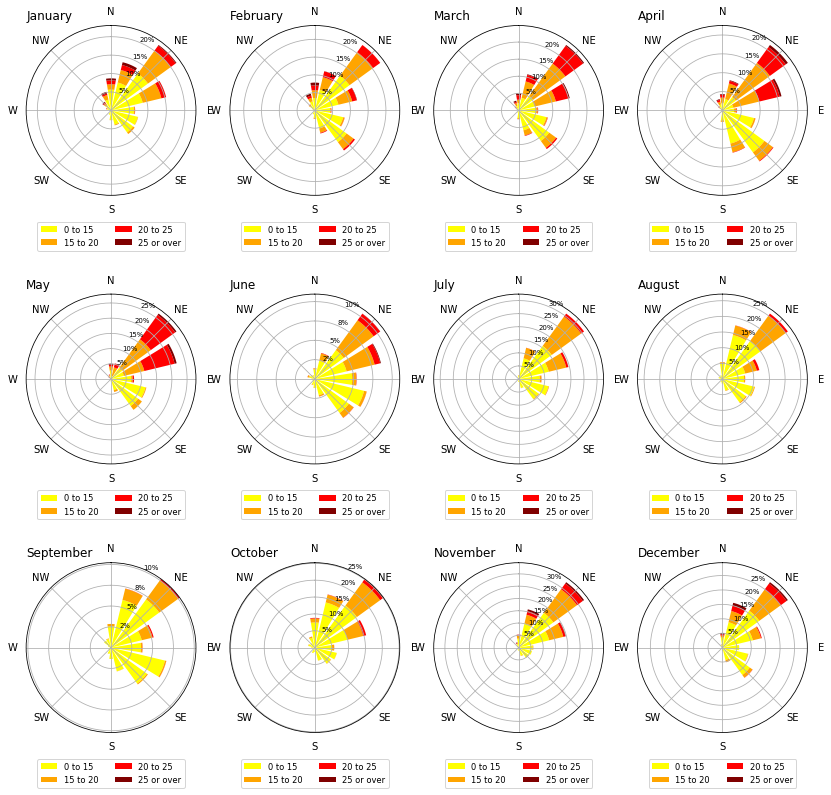

In [20]:
rangesSpec = [
    ('0 to 15','Yellow'),
    ('15 to 20','Orange'),
    ('20 to 25','Red'),
    ('25 or over','Maroon')
]
fig, axes = plotWindRose(normedWindRosePD,rangesSpec)
if DATABRICKS_ENV : display(fig)

#### Wind Rose Analysis

There are 2 dominant wind directions north-east and south-east. NE winds are stronger overall compared to the SE ones. This is good news since the NE direction creates a side-onshore direction excellent for kiting in the northern shore of Yucatan.

Visually we can observe that around september we get the lowest winds. The end of winter-spring months seem to have the highest winds overall.

### Search of Windy Days

The information from the wind rose is a good quick outlook of how to the winds distribute along the year but it doesn’t answer the question of how many good days for kiting a month has.

Everyday is scanned to look for a period of at least 2 hours of sustained winds in the ranges of 15, 20 and 25 mph. The fact that each day was resampled at 5 min intervals greatly simplifies this analysis since it becomes a grouping and counting problem rather than finding time differences.

#### Query for Periods of Time Longer Than 2 Hours

First step is to look for the amount of time the wind speed was equal or greater than 15, 20 and 25 mph respectively. A time range is only good if there is at least 2 hours of contiguous wind over the desired speed otherwise the range is discarded. If there are multiple periods going over the 2 hours threshold then they are added together.

In terms of SQL we filter when the speed is greater than the desired speed and we use a scaled ROW_NUMBER window function and the TSEpochSec to find contiguous measurements (A disruption on the difference tells us it is a different group.

In [21]:
def windyDaysQuery(windThreshold, timeThreshold) :
    queryStr = """
    SELECT Date, SUM(DayGroupCount) AS Total{windTh}
    FROM (
      SELECT Date, DayGroup, COUNT(1) as DayGroupCount
      FROM (
        SELECT *,
          TSEpochSec - {fiveMin}*(ROW_NUMBER() OVER (PARTITION BY Date ORDER BY TSEpochSec))
            AS DayGroup
        FROM (
          SELECT *
          FROM dayligthWindTable
          WHERE WindSpeedMPH >= {windTh}
        )
      )
      GROUP BY Date, DayGroup
    )
    WHERE DayGroupCount >= {timeTh}
    GROUP BY Date
    """.format(windTh=windThreshold, timeTh=timeThreshold, fiveMin=FIVE_MINUTES_IN_SECS)
    return spark.sql(queryStr)

windyDaysGtEq15DF = windyDaysQuery(15,TWO_HOURS_IN_5MINS)
windyDaysGtEq20DF = windyDaysQuery(20,TWO_HOURS_IN_5MINS)
windyDaysGtEq25DF = windyDaysQuery(25,TWO_HOURS_IN_5MINS)

#### Determine the Pseudo-Speed of the Day

As next step we join all the previous queries in a single table and we insert one more column called pseudoWindSpeedMPH. This captures the highest sustained speed above the predefined thresholds. If for instance there is a period of time that the wind blows for more than 2 hours at 25 mph then the pseudoWindSpeedMPH will be 25, if this is not the case then we look at the next range.

In [22]:
windyDaysDF = dayligthWindDF.select("Date").distinct().orderBy("Date") \
    .join(windyDaysGtEq15DF,["Date"],"left_outer") \
    .join(windyDaysGtEq20DF,["Date"],"left_outer") \
    .join(windyDaysGtEq25DF,["Date"],"left_outer") \
    .fillna(0) \
    .withColumn("pseudoWindSpeedMPH",
                when(col("Total25")>0,25)
                .when(col("Total20")>0,20)
                .when(col("Total15")>0,15)
                .otherwise(0) )

windyDaysDF.createOrReplaceTempView("windyDaysTable")

In [23]:
# TODO remove
windyDaysDF.coalesce(1).write \
    .option("header", "true") \
    .csv("output/windyDaysDF")

### Montly Report of Windy Days

A monthly report can be extracted from the daily report. The information extracted is how many windy days we can expect as a percentage in a given month.

#### Query the Proportion of Days

For each wind range the days are grouped by month and a proportion of how many windy days per month is calculated.

In [24]:
barChartDF = spark.sql("""
SELECT
  Month,
  SUM(gteq15)/COUNT(1) AS Ratio15,
  SUM(gteq20)/COUNT(1) AS Ratio20,
  SUM(gteq25)/COUNT(1) AS Ratio25
FROM (
  SELECT *,
    MONTH(Date) as Month,
    CASE WHEN Total15 > 0 THEN 1 ELSE 0 END AS gteq15,
    CASE WHEN Total20 > 0 THEN 1 ELSE 0 END AS gteq20,
    CASE WHEN Total25 > 0 THEN 1 ELSE 0 END AS gteq25
  FROM windyDaysTable
)
GROUP BY Month
ORDER BY Month
""")

barChartPD = barChartDF.toPandas()

#### Bar Chart Function

There will be 3 bars for each month, they will be overlapped so it is easier to see the proportions of the ranges.

In [25]:
def plotMonthlySummary(barChartPD,ranges) :
    fig, ax = plt.subplots(figsize=(10, 10))
    
    for i, (name,label,color,height) in enumerate(ranges) :
        ax.barh(
            barChartPD['Month'],
            barChartPD[name],
            height=height,
            align='center',
            color=color,
            edgecolor='Black',
            label=label,
            linewidth=0)

    months = list(map(lambda x : calendar.month_name[x],barChartPD['Month']))
    xticks = np.arange(0,100,10)/100
    ax.set_yticks(barChartPD['Month'], minor=False)
    ax.set_yticklabels(months, fontdict=None, minor=False)
    ax.set_xticks(xticks, minor=False)
    ax.set_xticklabels(map(lambda x : "{:.0%}".format(x),xticks), fontdict=None, minor=False)
    #ax.set_xticklabels(map(lambda x : "{:.0%}".format(x),ax.get_xticks()), fontdict=None, minor=False)
    ax.grid(linestyle='--',axis='x')
    ax.legend(loc='best')
    
    return (fig, ax)

#### Bar Chart Plot

The function receives an array of tuples that has the columns that we want to plot from the dataframe, the label that will be used for the column in the plot, the color that we want to use and the width.

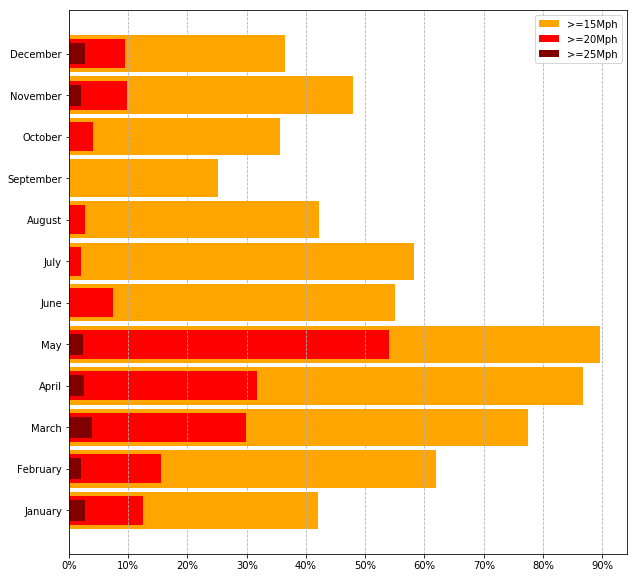

In [26]:
rangesSpec = [
    ('Ratio15','>=15Mph','Orange',0.9),
    ('Ratio20','>=20Mph','Red',0.7),
    ('Ratio25','>=25Mph','Maroon',0.5)
]

fig, ax = plotMonthlySummary(barChartPD,rangesSpec)
if DATABRICKS_ENV : display(fig)

### Calendar Report

The final task of this analysis is to plot the value of the pseudoWindSpeedMPH in a calendar.

#### Extracting Data

The query to be performed is straightforward it is just extracting the Date and the pseudoWindSpeedMPH to a pandas dataframe. However, the dataframe has to be processed to create a timeseries for the plotting library.

In [27]:
windyDaysPD = spark.sql("""
SELECT Date,pseudoWindSpeedMPH
FROM windyDaysTable
""").toPandas()
windyDaysEventsPD = windyDaysPD.set_index(pd.DatetimeIndex(windyDaysPD['Date']))['pseudoWindSpeedMPH']

#### Calendar Heatmaps

The library calmap is used to visualize the windy days. The darker the dot the higher the value of pseudoWindSpeedMPH. Calmap will show in gray the days with no reading.

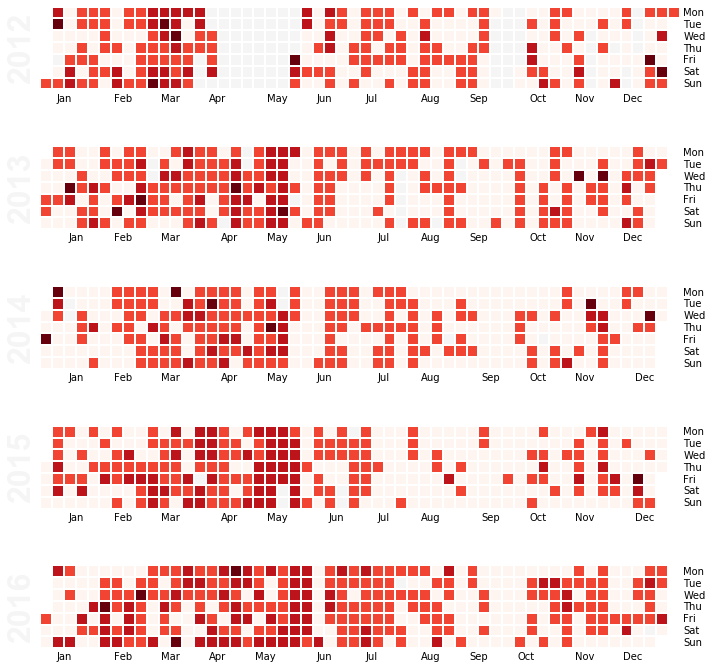

In [28]:
fig, axis = calmap.calendarplot(windyDaysEventsPD,linecolor='white', how=None ,fig_kws={'figsize':(10, 10)})
if DATABRICKS_ENV : display(fig)

## Conclusion

### Result Interpretation



### Future Improvements

This work only shows the handling of one sensor, it will be more interesting to convert this work to a wind mining engine. A few modifications have been identified:

__Multiple PWS analysis__: A single PWS data set is still small, the real power of having a cluster of machines will be unleashed if we can apply this analysis to multiple stations at the same time. To achieve this the following changes are needed: handling all the data in UTC, the sensor name has to go to the data set, another dataset has to be created with sensor locations and time zones.

__Correlation with other variables__: It is not only useful to know when is the good wind but also when is the good weather happening at the spot (Not too cold not too hot).

__Work with wunderground response__: The dataset for this analysis comes from an already formatted set of CSVs. Spark can be used to format the response reducing the job of the crawler script to just writing it to the file system.


#### Analysis of the Calendar Heatmaps